goal: classify a highly imbalanced dataset in which the number of examples in one class greatly outnumbers the examples in another.

In [35]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

* https://github.com/scikit-learn/scikit-learn
* https://github.com/scikit-learn-contrib/imbalanced-learn

In [36]:
# metrics
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    average_precision_score, balanced_accuracy_score,
    matthews_corrcoef, confusion_matrix
)
from imblearn.metrics import geometric_mean_score

In [37]:
# models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# %pip install xgboost
# import xgboost as xgb

dataset: [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset hosted on Kaggle. The aim is to detect the 492 fraudulent transactions from 284,807 transactions in total.

In [38]:
# Load the dataset
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')

In [39]:
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [40]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



In [41]:
# Drop the 'Time' column
raw_df = raw_df.drop(columns=['Time'])

## Ignoring the class imbalance

In [42]:
# Convert 'Amount' to log space
# eps = 0.001  # To avoid log(0)
# raw_df['Log Amount'] = np.log(raw_df.pop('Amount') + eps)

In [43]:
# Extract features and labels
X = raw_df.drop(columns=['Class'])
y = raw_df['Class']

In [44]:
# Logistic Regression Pipeline
log_reg_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(class_weight=None)) # solver='liblinear'
])

In [45]:
# KNN Pipeline
# this one takes too long so i'm excluding it for now
knn_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(weights='uniform'))
])

We observe that the parameter weights has an impact on the decision boundary. When weights="unifom" all nearest neighbors will have the same impact on the decision. Whereas when weights="distance" the weight given to each neighbor is proportional to the inverse of the distance from that neighbor to the query point.

In [46]:
# HistGradientBoostingClassifier pipeline
hgb_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('hgb', HistGradientBoostingClassifier(max_iter=100, random_state=42, class_weight=None))
])

In [47]:
# SVM with RBF kernel pipeline
# this one takes too long so i'm excluding it for now
svm_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42, class_weight=None)) # default kernel
])

* SVC(kernel='rbf'): This specifies the RBF kernel for the Support Vector Machine.
* probability=True: This allows us to compute the predicted probabilities (needed for PR-AUC and ROC-AUC).

In [48]:
# MLPClassifier pipeline
mlp_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=100, random_state=42))
])

* hidden_layer_sizes=(128, 64): Defines the architecture of the neural network with two hidden layers.
* max_iter=100: Limits the number of iterations for training.
* The MLPClassifier handles classification and is suitable for tabular data, but its performance can depend heavily on the choice of hyperparameters.

In [49]:
# Define evaluation metrics
def evaluate_model(y_true, y_pred, y_probs):
    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Metrics derived from the confusion matrix
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0  # Same as recall
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0  # Negative Predictive Value
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0  # False Positive Rate
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0  # False Negative Rate
    prevalence = (tp + fn) / (tp + tn + fp + fn)

    # Standard metrics
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred)  # Same as sensitivity
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_probs) if len(np.unique(y_true)) > 1 else 0.0
    pr_auc = average_precision_score(y_true, y_probs)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    gmean = geometric_mean_score(y_true, y_pred)

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall (Sensitivity)": recall,
        "Specificity": specificity,
        "Negative Predictive Value (NPV)": npv,
        "False Positive Rate (FPR)": fpr,
        "False Negative Rate (FNR)": fnr,
        "Prevalence": prevalence,
        "F1": f1,
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc,
        "Balanced Accuracy": balanced_acc,
        "MCC": mcc,
        "G-Mean": gmean
    }

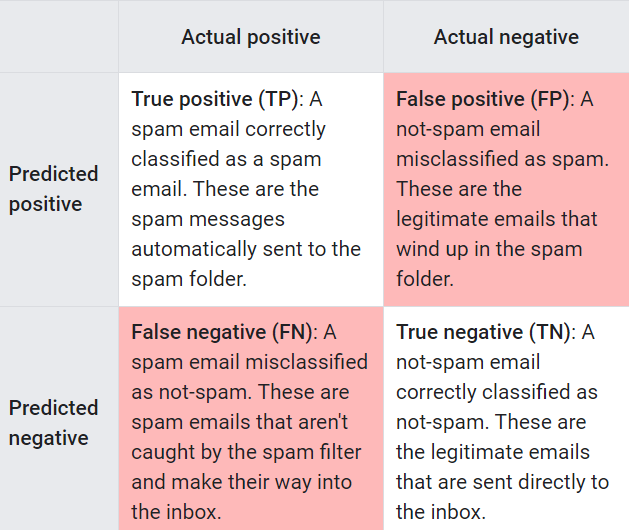

**Accuracy**: The ratio of correctly classified samples.
   $$
   \text{Accuracy} =
\frac{\text{correct classifications}}{\text{total classifications}}
= \frac{TP+TN}{TP+TN+FP+FN}
   $$

**Sensitivity (Recall or TPR)**: The proportion of actual positives correctly identified.
   $$
   \text{Recall (or Sensitivity or TPR)} =
\frac{\text{correctly classified actual positives}}{\text{all actual positives}}
= \frac{TP}{TP+FN}
   $$
**Specificity**: The proportion of actual negatives correctly identified.
   $$
   \text{Specificity} = \frac{TN}{TN + FP}
   $$
**Negative Predictive Value (NPV)**: The proportion of predicted negatives that are true negatives.
   $$
   \text{NPV} = \frac{TN}{TN + FN}
   $$
**False Positive Rate (FPR)**: The proportion of actual negatives incorrectly identified as positives.
   $$
   \text{FPR} = \frac{FP}{FP + TN}
   $$
**False Negative Rate (FNR)**: The proportion of actual positives incorrectly identified as negatives.
   $$
   \text{FNR} = \frac{FN}{FN + TP}
   $$
**Prevalence**: The proportion of positive cases in the dataset.
   $$
   \text{Prevalence} = \frac{TP + FN}{TP + TN + FP + FN}
   $$

In [50]:
# Perform k-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [51]:
models = {
    "Logistic Regression": log_reg_pipeline,
    "KNN": knn_pipeline
}

In [52]:
# Add the HistGradientBoostingClassifier model to the models dictionary
models["Histogram-based Gradient Boosting"] = hgb_pipeline

In [53]:
# models["SVM (RBF Kernel)"] = svm_pipeline
models["MLPClassifier"] = mlp_pipeline

<div style="color:red;">warning: 15min, or at best 5min (without the knn)</div> 😰

In [ ]:
results = {}

for model_name, pipeline in models.items():
    print(f"\nTraining model: {model_name}")
    fold_results = []
    for train_idx, test_idx in kf.split(X, y):
        print(f"  Fold: {len(fold_results) + 1}")
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Fit and predict
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_probs = pipeline.predict_proba(X_test)[:, 1]

        # Evaluate metrics
        metrics = evaluate_model(y_test, y_pred, y_probs)
        fold_results.append(metrics)

    # Aggregate results
    results[model_name] = pd.DataFrame(fold_results).mean().to_dict()


Training model: Logistic Regression
  Fold: 1
  Fold: 2
  Fold: 3
  Fold: 4
  Fold: 5

Training model: KNN
  Fold: 1
  Fold: 2
  Fold: 3
  Fold: 4
  Fold: 5

Training model: Histogram-based Gradient Boosting
  Fold: 1
  Fold: 2
  Fold: 3
  Fold: 4
  Fold: 5

Training model: MLPClassifier
  Fold: 1
  Fold: 2
  Fold: 3


In [ ]:
results_df = pd.DataFrame(results).T
results_df

In [ ]:
results_df.to_csv('results.csv', index=True)  # index=True includes the index in the CSV

## Dealing with imbalance

Only one strategy will be used - the one described in here

https://developers.google.com/machine-learning/crash-course/overfitting/imbalanced-datasets

* Step 1: Downsample the majority class.
* Step 2: Upweight the downsampled class

<table>
<thead>
<tr>
<th>Percentage of data belonging to minority class</th>
<th>Degree of imbalance</th>
</tr>
</thead>

<tbody>
<tr>
<td>20-40% of the dataset</td>
<td>Mild</td>
</tr>
<tr>
<td>1-20% of the dataset</td>
<td>Moderate</td>
</tr>
<tr>
<td>&lt;1% of the dataset</td>
<td>Extreme</td>
</tr>
</tbody>
</table>

In [ ]:
# Define class distribution for undersampling
minority_ratio = 0.2  # Desired ratio of minority class
majority_ratio = 1 - minority_ratio

In [ ]:
# Define class weights based on original data distribution
neg, pos = np.bincount(y)
class_weight = {0: len(y) / (2 * neg), 1: len(y) / (2 * pos)}

In [ ]:
log_reg_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('undersample', RandomUnderSampler(sampling_strategy=minority_ratio, random_state=42)),
    ('logreg', LogisticRegression(class_weight=class_weight))
])

In [ ]:
# this one is without custom weights
knn_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('undersample', RandomUnderSampler(sampling_strategy=minority_ratio, random_state=42)),
    ('knn', KNeighborsClassifier(weights='uniform'))
])

In [ ]:
hgb_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('undersample', RandomUnderSampler(sampling_strategy=minority_ratio, random_state=42)),
    ('hgb', HistGradientBoostingClassifier(max_iter=100, random_state=42))
])

In [ ]:
# class_weight='balanced'  # or a dictionary of weights
svm_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('undersample', RandomUnderSampler(sampling_strategy=minority_ratio, random_state=42)),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42, class_weight=class_weight))
])

* class_weight='balanced': This automatically adjusts weights to handle class imbalance.

In [ ]:
mlp_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('undersample', RandomUnderSampler(sampling_strategy=minority_ratio, random_state=42)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=100, random_state=42))
]) # does not support the class_weight parameter

In [ ]:
# kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
models = {
    "Logistic Regression": log_reg_pipeline,
    "KNN": knn_pipeline,
    "Histogram-based Gradient Boosting": hgb_pipeline,
    "SVM (RBF Kernel)": svm_pipeline,
    "MLPClassifier": mlp_pipeline
}

In [ ]:
results = {}

for model_name, pipeline in models.items():
    print(f"\nTraining model: {model_name}")
    fold_results = []
    for train_idx, test_idx in kf.split(X, y):
        print(f"  Fold: {len(fold_results) + 1}")
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Fit and predict
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_probs = pipeline.predict_proba(X_test)[:, 1]

        # Evaluate metrics
        metrics = evaluate_model(y_test, y_pred, y_probs)
        fold_results.append(metrics)

    # Aggregate results
    results[model_name] = pd.DataFrame(fold_results).mean().to_dict()

In [ ]:
results_df = pd.DataFrame(results).T
results_df

In [ ]:
# need to downsample first... TODO
"""
# Custom weight function for KNeighborsClassifier
def custom_weights(distances):
    return 1 / (distances + 1e-5)  # Inverse distance weighting

# Function to perform cross-validation
def cross_validate_knn(X, y, class_weight, n_neighbors=5):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):
        print(f"Fold {fold}:")
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Create and fit KNeighborsClassifier with custom weights
        knn = KNeighborsClassifier(n_neighbors=n_neighbors,
                                   weights=custom_weights,  # Use custom weighting
                                   metric='minkowski')
        knn.fit(X_train, y_train)

        # Predict and evaluate
        y_pred = knn.predict(X_test)
        y_probs = knn.predict_proba(X_test)[:, 1]

        # Evaluate metrics
        metrics = evaluate_model(y_test, y_pred, y_probs)
        fold_results.append(metrics)

    # Aggregate results
    results = pd.DataFrame(fold_results).mean().to_dict()
    return results

# Example usage
results = cross_validate_knn(X, y, class_weight, n_neighbors=5)
print("Cross-Validation Results:", results)
"""

### Precision and Recall Analysis:
- **Precision**: A low precision indicates that the model is often predicting false positives. In the context of fraud detection (assuming you're working with financial data), the model might be predicting legitimate transactions as fraudulent (i.e., predicting a positive class when it's actually negative).
  
- **Recall**: A high recall suggests that the model is good at detecting the true positives (fraudulent transactions in this case), meaning it's identifying most of the fraudulent cases but with many false positives.

In imbalanced datasets (like fraud detection, where fraudulent transactions are rare), models tend to favor the majority class (non-fraudulent), so you see this trade-off where **recall is high, but precision is low**. This is especially true when trying to capture as many fraudulent transactions as possible.

### Why this happens:
- **Imbalanced Classes**: The dataset is heavily imbalanced, with a very small percentage of fraudulent transactions. Many models will classify a lot of legitimate transactions (the majority class) as negative and predict fraudulent transactions (the minority class) less accurately.
- **Class Imbalance Handling**: In imbalanced datasets, it is common for recall to be prioritized because detecting all fraudulent cases (even with many false positives) is often seen as more critical than minimizing false positives.

### Which model performs best?
Let's review the models' performance:

#### Key Observations:
1. **Logistic Regression**:  
   - **Precision is very low**, which suggests it's making too many false positive predictions. It's good at **recall** (detecting the majority of fraudulent cases) but at the cost of precision.
   
2. **KNN**:
   - **Precision and Recall** are more balanced than Logistic Regression. **Good F1** score and **Balanced Accuracy** indicate it's doing well overall, but may still be struggling with the class imbalance, just less so than Logistic Regression.

3. **Histogram-based Gradient Boosting**:
   - **High ROC-AUC and PR-AUC**: This model stands out as it offers excellent ability to distinguish between classes. The **high recall** and **good precision** indicate that it is doing a better job at handling the imbalance.

4. **SVM (RBF Kernel)**:
   - **Slightly better precision** compared to the previous models but still not great. The **high recall** shows that it's identifying a good amount of fraudulent transactions, and it has a solid **balanced accuracy**. This model seems to be quite competitive.

5. **MLPClassifier**:
   - **Better F1 score than SVM**: This model is showing good performance with **balanced precision and recall**, and **excellent G-Mean** and **Balanced Accuracy**, meaning it's good at handling the class imbalance.
   - **Very high PR-AUC**: This model seems to be the best at capturing the minority class (fraudulent transactions).

### The Best Model:
From your results, **MLPClassifier** seems to be the best-performing model overall based on these metrics:
- **Balanced Accuracy**: Shows the model is handling both classes well.
- **F1 Score**: Indicates a better trade-off between precision and recall.
- **PR-AUC and G-Mean**: Suggest it is excellent at capturing the minority class (fraudulent transactions).
  
It also performs **better than the SVM with RBF kernel** and **Gradient Boosting** in terms of overall F1 and G-Mean, making it a strong contender.

### Recommendations:
- **Tune the Model**: If you have the resources, you can try tuning the **MLPClassifier** (e.g., adjusting the number of layers, learning rate, etc.). Sometimes a simple adjustment can lead to even better performance.
- **Class Weight Adjustments**: For SVM, KNN, and other models, adjusting class weights (like you did with `SVC(class_weight='balanced')`) can sometimes improve performance.
- **Try Feature Engineering**: If the current set of features is not capturing the problem well, additional feature engineering might help, such as aggregating transaction data or extracting domain-specific features related to fraudulent transactions.

### Conclusion:
- **Best Model**: **MLPClassifier** appears to be the best performing based on your metrics.
- **Trade-off between Precision and Recall**: In imbalanced datasets, it’s common for recall to be high but precision to be low. Focusing on the **PR-AUC** and **F1 score** will give you a more holistic view of the model’s performance.
  
Would you like to try further tuning the MLP or explore other adjustments?